In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pylab import rcParams
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from ggplot import *

/home/ramon/anaconda2/lib/python2.7/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/ramon/anaconda2/lib/python2.7/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/ramon/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df_listing_high_renter = pd.read_csv('data/df_listing_high_renter.csv')

## Brightness and contrasts

In [3]:
df_contrasts_brightness =pd.read_csv('data/df_contrasts_brightness.csv')

df_contrasts_brightness=pd.merge(df_contrasts_brightness,df_listing_high_renter[['id','review_scores_rating','reviews_per_month','availability_90','price']],left_on='listing_id',right_on='id')

df_contrasts_brightness.corr()[['availability_90']]

,availability_90
listing_id,0.073245
R_contrast,0.018924
G_contrast,-0.001540
B_contrast,-0.031066
Brightness_mean,-0.018306
Brightness_std,-0.001834
id,0.073245
review_scores_rating,-0.125867
reviews_per_month,-0.023449
availability_90,1.000000


## Greyscale patterns

In [4]:


df_pictures = pd.read_csv('data/df_pictures_listing.csv',index_col=0)
cols = ["pix_"+ str(i) for i in range(0,df_pictures.shape[1]-1)]
df_pictures=pd.merge(df_pictures,df_listing_high_renter[['id','review_scores_rating','reviews_per_month','availability_90','price']],left_on='listing_id',right_on='id')

In [5]:
df_pictures['availability_quartile'] = pd.qcut(df_pictures.availability_90,4)
df_pictures['reviews_per_month_quartile'] = pd.qcut(df_pictures.reviews_per_month,4)

In [6]:
from numpy.random import RandomState
n_row, n_col = 2,3
n_components = n_row * n_col
image_shape = (64, 64)
rng = RandomState(0)

hfont = {'fontname':'Computer Modern'} 

def plot_gallery(title, images, n_col=n_col, n_row=n_row):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16, **hfont)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.Accent,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

In [7]:
def prepare_pictures_pca(group,name):
    X_data = group[cols].values
    n_samples, n_features = X_data.shape

    # global centering
    faces_centered = X_data - X_data.mean(axis=0)

    # local centering
    faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)
    print X_data.shape
    pca = PCA(n_components=n_components, svd_solver='randomized',
                       whiten=True)
    pca.fit(faces_centered)
    components_ =pca.components_
    plot_gallery('Eigen pictures for availability_90 in '+str(name),
                 components_[:n_components])


(809, 4096)
(812, 4096)
(803, 4096)
(774, 4096)


/home/ramon/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'Computer Modern'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


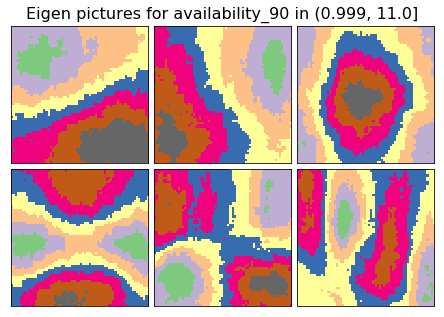

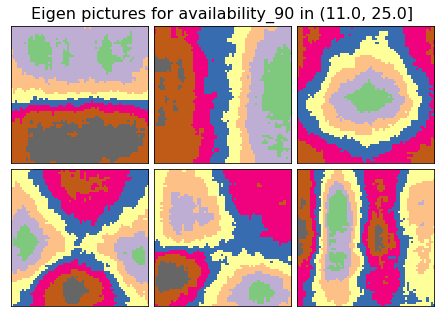

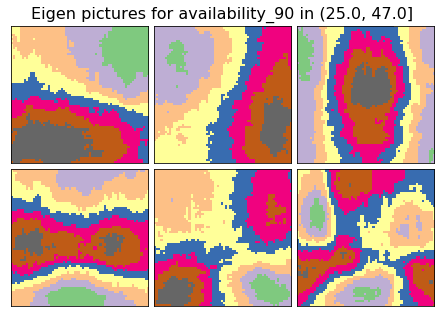

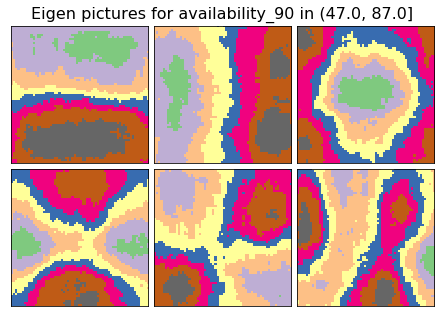

In [8]:
groupy_pictures= df_pictures.groupby('availability_quartile')

for name,group in groupy_pictures:
    prepare_pictures_pca(group,name)


## PCA on greyscale

/home/ramon/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


35.9697459149


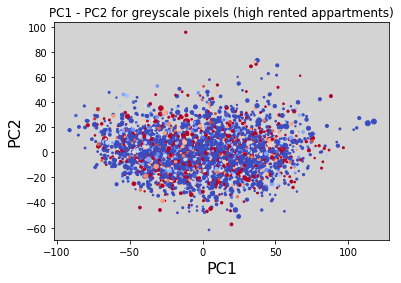

In [9]:
pca = PCA(n_components=50)
fig, plot = plt.subplots()
plot.set_facecolor('lightgrey')

X_train = scale(df_pictures[cols].values)
y_train = df_pictures['availability_90'].values
z_train = df_pictures['reviews_per_month']*3


X_transformed = pca.fit_transform(X_train)

print pca.explained_variance_ratio_[:2].sum()*100


colors = plt.cm.coolwarm(scale(y_train))


plot.scatter(X_transformed[:, 0], X_transformed[:, 1], c=colors,s=z_train,alpha=1)

plot.set_ylabel('PC2', size=16)
plot.set_xlabel('PC1', size=16)
plot.set_title('PC1 - PC2 for greyscale pixels (high rented appartments)', size=12, **hfont)

df_pictures['PC_1'] = X_transformed[:, 0]
df_pictures['PC_2'] = X_transformed[:, 2]

## Colors Rainbows

In [10]:
df_colors_cluster=pd.read_csv('data/df_colours_clusters.csv')
df_colors_cluster=pd.merge(df_colors_cluster,df_listing_high_renter[['id','review_scores_rating','reviews_per_month','availability_90','price']],left_on='listing_id',right_on='id')

In [11]:
df_colors_cluster['availability_quartile'] = pd.qcut(df_colors_cluster.availability_90,10)
df_colors_cluster['reviews_per_month_quartile'] = pd.qcut(df_colors_cluster.reviews_per_month,10)

In [12]:
def get_clusters_colors(df,availability_90, higher=True,n_clusters=10):
    
    
    X_colors_centroids = df[['Centroid_R_1','Centroid_G_1','Centroid_B_1']].values
    clt = KMeans(n_clusters = n_clusters)
    clt.fit(X_colors_centroids)
    list_col=[]

    for i in range(0,clt.cluster_centers_.shape[0]):
        arr_col = clt.cluster_centers_[i]/255
        
        list_col.append((arr_col.tolist()))
        
    list_col.sort()
    return list_col

(0.999, 5.0]
(5.0, 9.0]
(9.0, 14.0]
(14.0, 19.0]
(19.0, 25.0]
(25.0, 32.0]
(32.0, 41.0]
(41.0, 53.0]
(53.0, 67.0]
(67.0, 87.0]


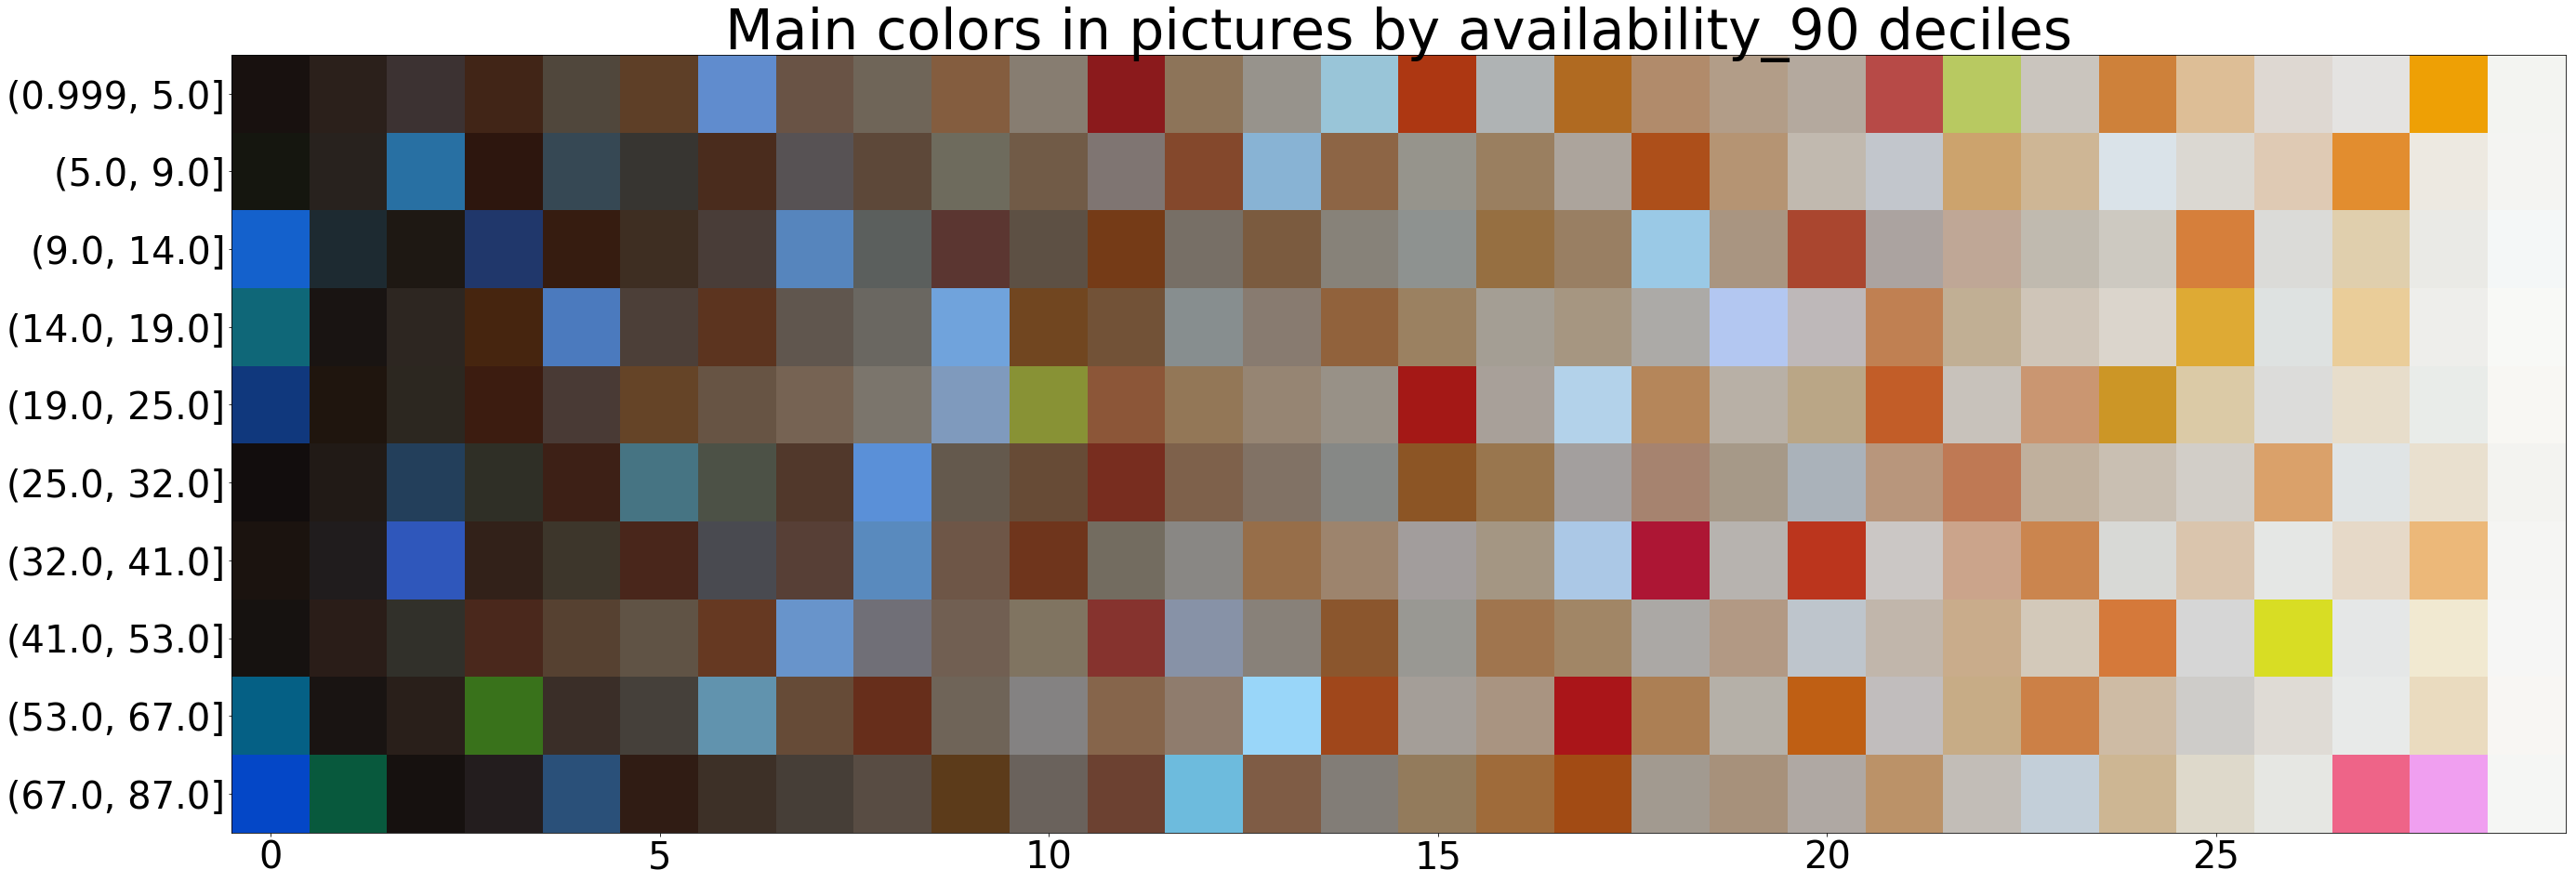

In [13]:
groupy_colors_clusters = df_colors_cluster.groupby('availability_quartile')

list_all_colors_clusters = []
for name,group in groupy_colors_clusters:
    print name
    list_all_colors_clusters.append(get_clusters_colors(group, 10,False,n_clusters=30))  
    
fig_size = plt.rcParams["figure.figsize"]
 
plt.figure(figsize=(45,30))

plt.yticks(range(0,11),[str(quantile_name) for quantile_name, _  in groupy_colors_clusters])
plt.tick_params(axis='both', which='major', labelsize=40)

plt.title('Main colors in pictures by availability_90 deciles', fontsize=60)
plt.imshow([c for c in list_all_colors_clusters])

In [14]:
df_colors_cluster.corr()[['review_scores_rating','availability_90']].sort_values(by='availability_90')

,review_scores_rating,availability_90
review_scores_rating,1.000000,-0.125836
reviews_per_month,-0.059182,-0.023410
Centroid_B_4,0.017235,-0.019328
Centroid_G_4,0.010054,-0.018775
Centroid_R_2,-0.017758,-0.018096
Centroid_G_2,-0.013181,-0.015922
Centroid_R_1,-0.030640,-0.015524
Centroid_R_4,0.001515,-0.014687
Centroid_G_3,0.037052,-0.012645
Centroid_B_3,0.036678,-0.012475


In [15]:
cols_int = [col for col in df_colors_cluster.columns if 'Centroid' in col]
cols_int = [col for col in cols_int if 'hex' not in col]

pca = PCA(n_components=6)

X_train = scale(df_colors_cluster[cols_int].values)
y_train = df_colors_cluster['availability_90'].values
z_train = df_colors_cluster['reviews_per_month']*5

X_transformed = pca.fit_transform(X_train)
print pca.explained_variance_ratio_.sum()*100



78.5824933114


In [16]:
df_pca = pd.DataFrame({'PC1':X_transformed[:, 0],'PC2': X_transformed[:, 1], 'availability_90':(y_train),'reviews_per_month':z_train})

In [17]:
df_pca.reviews_per_month=df_pca.reviews_per_month.astype(int)
df_pca.availability_90=df_pca.availability_90.astype(int)

airBColor= '#ff5a5f'
airBColor2='#008489'

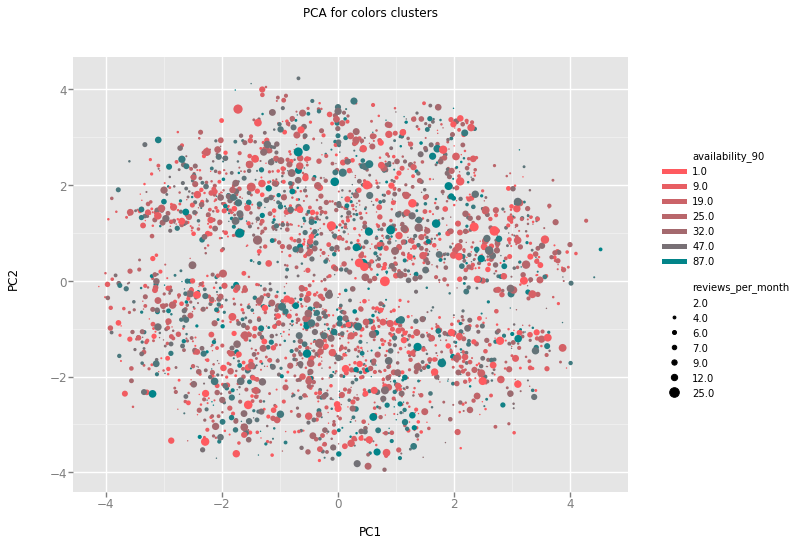

<ggplot: (8738807504369)>

In [21]:
ggplot(df_pca,aes(x='PC1',y='PC2',color='availability_90',size='reviews_per_month'))+geom_point()+scale_color_gradient(low = airBColor, high =airBColor2)+ ggtitle('PCA for colors clusters')

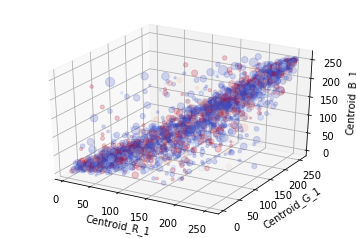

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

n = 100
rcParams['figure.figsize'] = 12, 12
# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].

colors = plt.cm.coolwarm(scale(df_colors_cluster['availability_90']))

xs = df_colors_cluster['Centroid_R_1']
ys = df_colors_cluster['Centroid_G_1']
zs = df_colors_cluster['Centroid_B_1']
ax.scatter(xs, ys, zs,c=colors,alpha=.2,s=df_colors_cluster['reviews_per_month']*10)


ax.set_xlabel('Centroid_R_1')
ax.set_ylabel('Centroid_G_1')
ax.set_zlabel('Centroid_B_1')



plt.show()
